In [1]:
#matrix factorization
import pandas as pd
import numpy as np
import implicit as im
from scipy.sparse import csr_matrix
import random
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
#read data
proc_dir = "../data/processed"

customers = pd.read_csv(proc_dir+"/customers.csv")
customers = customers['user']
games = pd.read_csv(proc_dir+"/games.csv")
games = games['game']
hours = pd.read_csv(proc_dir+"/hours.csv")
hours = hours[['userIndex', 'gameID', 'hours']]

In [3]:
def getPopularSampleData(users, items, ratings, size, rseed=43):
    #create list of popular items
    itemsGrouped = ratings.groupby('gameID', as_index=False).agg({"hours": "count"})
    popularItems = itemsGrouped[itemsGrouped.hours > 50]
    popularItems = popularItems['gameID']
    random.seed(rseed)
    randomSampleItems = map(int, random.sample(popularItems,size))
    #get all users who rated this item
    userRatedItems = ratings[ratings.gameID.isin(randomSampleItems)]
    #filter to only users who are active and played at least 2 games
    usersGrouped = userRatedItems.groupby('userIndex', as_index=False).agg({'hours':'count'})
    activeUsers = usersGrouped[usersGrouped.hours > 1]
    activeUsers = activeUsers['userIndex']
    finalRatings = userRatedItems[userRatedItems.userIndex.isin(activeUsers)]
    sampleUsers = map(int, finalRatings['userIndex'].unique())
    #return sample users and items
    return sampleUsers, randomSampleItems, finalRatings

def getTrainTestData(ratings, percent=.2, rseed=43):
    random.seed(rseed)
    testCount = int(len(ratings)*percent)
    testRows = random.sample(range(0,len(ratings)-1),testCount)
    trainRatings = pd.DataFrame(columns=['userIndex','gameID','hours'])
    testRatings = pd.DataFrame(columns=['userIndex','gameID','hours'])
    ind=0
    for index, row in ratings.iterrows():
        if(ind in testRows):
            testRatings = testRatings.append({'userIndex':row['userIndex'],
                                              'gameID':row['gameID'],
                                              'hours':row['hours']}, ignore_index=True)
        else:
            trainRatings = trainRatings.append({'userIndex':row['userIndex'],
                                                'gameID':row['gameID'],
                                                'hours':row['hours']}, ignore_index=True)
        ind=ind+1
    return trainRatings, testRatings

def squaredError(users, items, R, testRatings):
    error=0
    for index, row in testRatings.iterrows():
        error+=(R[users.index(row['userIndex'])][items.index(row['gameID'])]-row['hours'])**2
    return error

def column(matrix, i):
    return [row[i] for row in matrix]

def correctRecommendations(users, items, model, matrix, testRatings, topK=10):
    recommended=0
    missed=0
    for index, row in testRatings.iterrows():
        topRecommends = column(model.recommend(users.index(row['userIndex']), matrix, topK),0)
        if(items.index(row['gameID']) in topRecommends):
            recommended+=1
        else:
            missed+=1
    return recommended, missed

In [4]:
#get the random sample with designated size
users, items, ratings = getPopularSampleData(customers, games, hours, 95, 26)
#get train and test data
trainRatings, testRatings = getTrainTestData(ratings, .1, rseed=26)
print 'train ratings:', len(trainRatings)
print 'test ratings:', len(testRatings)
print testRatings.head()

train ratings: 11763
test ratings: 1306
   userIndex  gameID  hours
0        2.0    29.0   13.8
1        3.0    46.0   86.0
2       15.0    23.0    2.3
3       47.0    40.0    0.3
4       54.0   489.0    0.7


In [5]:
#create sparse train matrix games by customers with ratings - hours
M=np.zeros((len(items),len(users)))

for index, row in trainRatings.iterrows():
    M[items.index(row['gameID'])][users.index(row['userIndex'])]=row['hours']
M2 = csr_matrix(M)

print M.shape

(95, 2395)


In [9]:
#matrix factorization model
model = im.als.AlternatingLeastSquares(factors=6,iterations=2000, regularization=0.01)
model.fit(M2)

#factored U users and V items matrices
U = model.user_factors
V = model.item_factors

user_games = M2.T.tocsr()
recommendations = model.recommend(2, user_games,10)
print recommendations

100%|██████████| 2000.0/2000 [00:15<00:00, 125.01it/s]

[(30, 1.0726473), (21, 1.0503933), (84, 1.0112362), (32, 1.0096848), (75, 0.97305423), (15, 0.96886289), (62, 0.83845484), (22, 0.82148594), (50, 0.8094098), (45, 0.79871601)]


In [12]:
#real example show
print 'Customer:', customers[3]
print 'Test Data: Played 86 hours of', games[46]
print 'Our model recommended top 10 games below:'
print games[items[30]]
print games[items[21]]
print games[items[84]]
print games[items[32]]
print games[items[75]]
print games[items[15]]
print games[items[62]]
print games[items[22]]
print games[items[50]]
print games[items[45]]

Customer: 53875128
Test Data: Played 86 hours of Grand Theft Auto V
Our model recommended top 10 games below:
Grand Theft Auto V
Battlefield Bad Company 2
Call of Duty Modern Warfare 2 - Multiplayer
Fallout 4
Counter-Strike Source
Hitman Absolution
Tomb Raider
Grand Theft Auto San Andreas
BioShock Infinite
Mount & Blade Warband


In [15]:
#learned recommendations
R = np.matmul(U,np.transpose(V))

print 'U', U.shape, ',', 'V', V.shape, ',', 'R', R.shape

 U (2395, 6) , V (95, 6) , R (2395, 95)


In [16]:
#get accuracy from test data
print 'squared error:', squaredError(users, items, R, testRatings)
print 'number of accurate top 10 recommendations out of', len(testRatings),':', correctRecommendations(users, items, model, user_games, testRatings, 10)[0]

squared error: 27463102.0675
number of accurate top 10 recommendations out of 1306 : 570


In [312]:
#change in factors vs squared error and correct recommendations
factors=[2,4,6,8,10,12,14,16,18,20]
sqErr=[]
corrRecom=[]
for f in factors:
    mf = im.als.AlternatingLeastSquares(factors=f,iterations=2000, regularization=.01)
    mf.fit(M2)
    U1 = mf.user_factors
    V1 = mf.item_factors
    user_games1 = M2.T.tocsr()
    R1 = np.matmul(U1,np.transpose(V1))
    sqErr.append(squaredError(users, items, R1, testRatings))
    corrRecom.append(correctRecommendations(users, items, mf, user_games1, testRatings, 10)[0])
print 'done'

100%|██████████| 2000.0/2000 [00:14<00:00, 137.13it/s]
100%|██████████| 2000.0/2000 [00:17<00:00, 115.84it/s]
100%|██████████| 2000.0/2000 [00:17<00:00, 116.77it/s]
100%|██████████| 2000.0/2000 [00:18<00:00, 105.47it/s]
100%|██████████| 2000.0/2000 [00:21<00:00, 94.84it/s] 
100%|██████████| 2000.0/2000 [00:18<00:00, 106.92it/s]
100%|██████████| 2000.0/2000 [00:18<00:00, 109.25it/s]
100%|██████████| 2000.0/2000 [00:17<00:00, 114.77it/s]
100%|██████████| 2000.0/2000 [00:25<00:00, 77.01it/s]
100%|██████████| 2000.0/2000 [00:19<00:00, 102.95it/s]


done


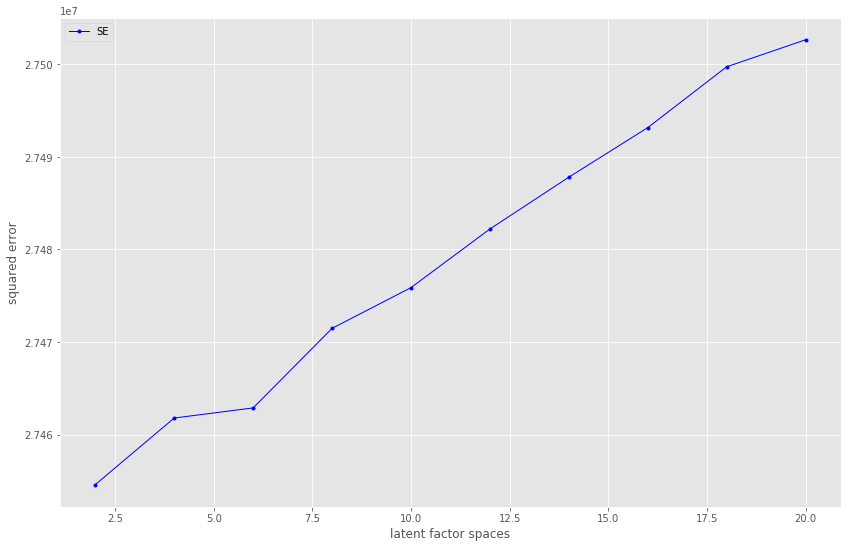

In [325]:
#plot factors vs error
    
plot1=pd.DataFrame({'factors':factors,'sqErr':sqErr, 'corrRecom':corrRecom})
plt.plot('factors', 'sqErr', data=plot1, label='SE', 
         marker='o', markerfacecolor='blue', markersize=3, color='blue', linewidth=1)
plt.xlabel('latent factor spaces')
plt.ylabel('squared error')
plt.legend()
plt.rcParams["figure.figsize"] = [14,9]
plt.show()

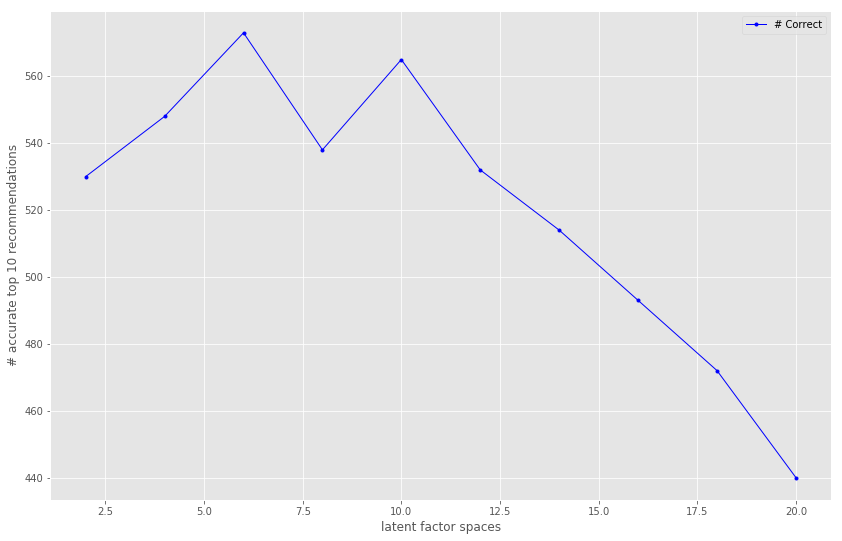

In [326]:
#plot factors vs percent recommendation correctness
plt.plot('factors', 'corrRecom', data=plot1, label='# Correct', 
         marker='o', markerfacecolor='blue', markersize=3, color='blue', linewidth=1)
plt.xlabel('latent factor spaces')
plt.ylabel('# accurate top 10 recommendations')
plt.legend()
plt.rcParams["figure.figsize"] = [14,9]
plt.show()